In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [5]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "family",
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 104 files belonging to 5 classes.


In [6]:
class_names = df.class_names
print(class_names)

['hemraj', 'kiran', 'mandar', 'mohan', 'sangita']


In [7]:
len(df)

4

In [8]:
for image_batch, label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 4 0 2 2 0 4 3 4 3 3 4 0 4 3 3 3 4 1 1 2 1 3 4 4 0 0 4 1 1 1 0]


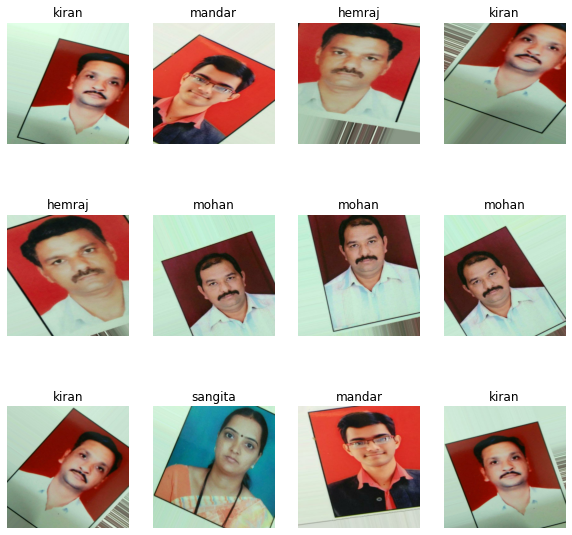

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
train_size = 0.8
len(df)*train_size

3.2

In [11]:
train_ds = df.take(54)
len(train_ds)

4

In [12]:
test_ds = df.skip(54)
len(test_ds)

0

In [13]:
val_size=0.1
len(df)*val_size

0.4

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [18]:
len(train_ds)

3

In [19]:
len(val_ds)

0

In [20]:
len(test_ds)

1

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 6s 2s/step - loss: 1.6107 - accuracy: 0.1944
Epoch 2/50
3/3 [==============================] - 5s 1s/step - loss: 1.5898 - accuracy: 0.3333
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 1.5056 - accuracy: 0.4028
Epoch 4/50
3/3 [==============================] - 5s 1s/step - loss: 1.3416 - accuracy: 0.4306
Epoch 5/50
3/3 [==============================] - 5s 1s/step - loss: 1.4112 - accuracy: 0.4167
Epoch 6/50
3/3 [==============================] - 5s 1s/step - loss: 1.1409 - accuracy: 0.5000
Epoch 7/50
3/3 [==============================] - 5s 1s/step - loss: 1.0316 - accuracy: 0.5556
Epoch 8/50
3/3 [==============================] - 5s 1s/step - loss: 1.0644 - accuracy: 0.5000
Epoch 9/50
3/3 [==============================] - 5s 1s/step - loss: 0.9840 - accuracy: 0.5556
Epoch 10/50
3/3 [==============================] - 5s 1s/step - loss: 0.7643 - accuracy: 0.6667
Epoch 11/50
3/3 [==============================] 

In [33]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 762ms/step - loss: 0.1409 - accuracy: 0.9688


In [36]:
acc = history.history['accuracy']
loss = history.history['loss']

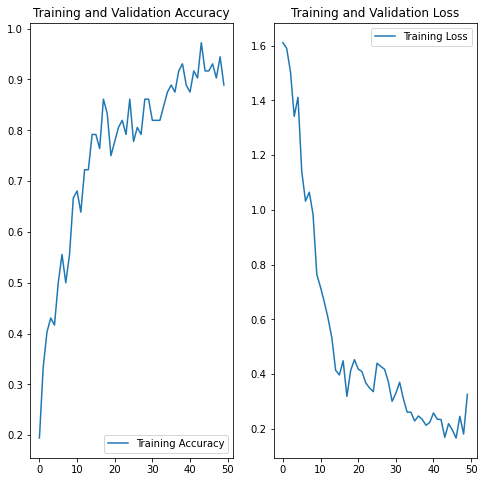

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: hemraj
predicted label: hemraj


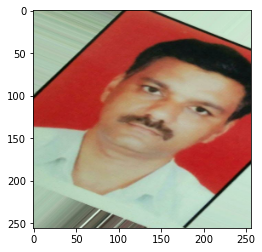

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

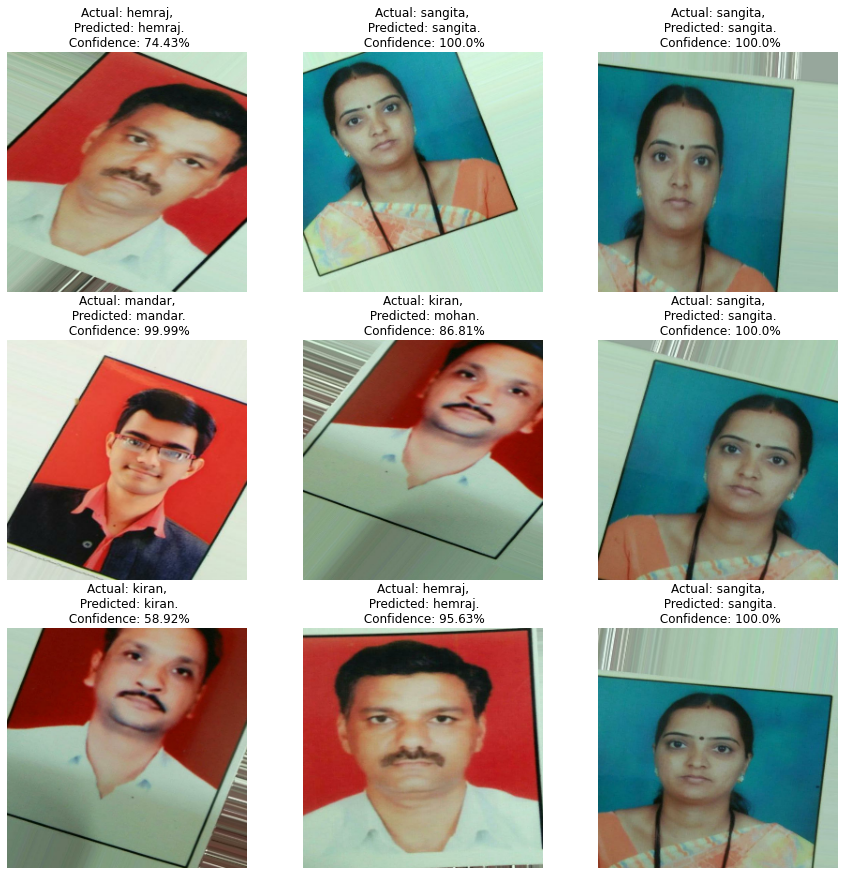

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")